In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# 检查GPU是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# 数据预处理和加载
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [9]:
# 生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(10, 10)  # 10个数字类别的嵌入向量
        self.main = nn.Sequential(
            nn.Linear(110, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, x, labels):
        x = torch.cat((x, self.embed(labels)), dim=1)  # 将输入向量和标签嵌入向量连接起来
        return self.main(x)

# 判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(10, 10)  # 10个数字类别的嵌入向量
        self.main = nn.Sequential(
            nn.Linear(28*28+10, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 输出层使用Sigmoid激活函数
        )

    def forward(self, x, labels):
        x = torch.cat((x, self.embed(labels)), dim=1)  # 将输入向量和标签嵌入向量连接起来
        return self.main(x)

# 实例化模型并移动到GPU
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [10]:
# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [11]:
num_epochs = 5
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        # 准备真实数据
        real_imgs = imgs.view(imgs.size(0), -1).to(device)
        labels = labels.to(device)

        # 训练判别器
        optimizer_D.zero_grad()
        
        z = torch.randn(imgs.size(0), 100).to(device)
        fake_imgs = generator(z, labels)
        outputs_real = discriminator(real_imgs, labels)
        d_loss_real = criterion(outputs_real, torch.ones(imgs.size(0), 1).to(device))
        outputs_fake = discriminator(fake_imgs.detach(), labels)
        d_loss_fake = criterion(outputs_fake, torch.zeros(imgs.size(0), 1).to(device))
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # 训练生成器
        optimizer_G.zero_grad()
        
        outputs_fake = discriminator(fake_imgs, labels)
        g_loss = criterion(outputs_fake, torch.ones(imgs.size(0), 1).to(device))
        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

Epoch [1/5], d_loss: 1.1159, g_loss: 2.2456
Epoch [2/5], d_loss: 0.4508, g_loss: 3.6827
Epoch [3/5], d_loss: 0.2209, g_loss: 5.0046
Epoch [4/5], d_loss: 0.0868, g_loss: 7.3644
Epoch [5/5], d_loss: 0.0571, g_loss: 4.9194


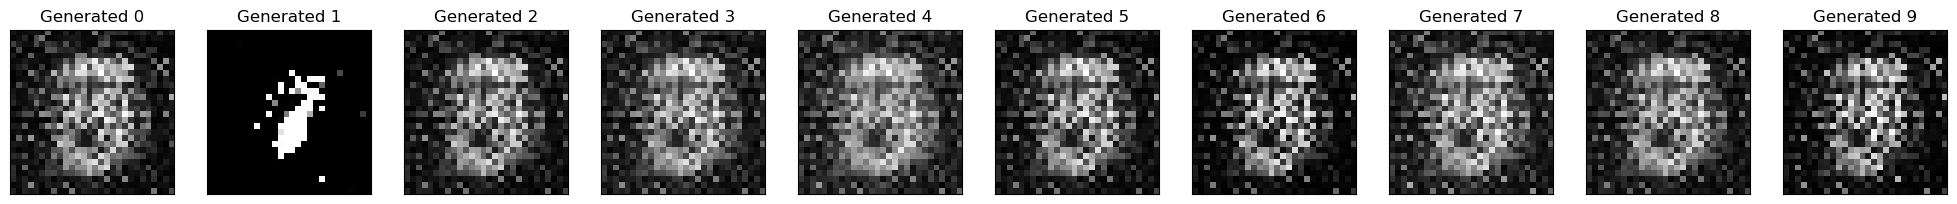

In [12]:
# 生成新图像
with torch.no_grad():
    z = torch.randn(10, 100).to(device)
    labels = torch.LongTensor([i for i in range(10)]).to(device)
    generated_imgs = generator(z, labels).view(-1, 1, 28, 28).cpu()

# 可视化生成的新图像
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for i in range(10):
    axes[i].imshow(generated_imgs[i].squeeze(), cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(f"Generated {i}")

plt.show()